# If the Hudson River increased by 2 C, how would the balance of heterotrophic and autotrophic processes change?

This is a lab notebook for an experiment conducted October 16-17th 2015 for Andy Juhl's <i>Introductory to Oceanography Course</i> at Lamont-Doherty Earth Institute. Measurements were taken off Piermont Pier Saturday October 16th on the surface with 1% light level of 10 cm . Samples were placed into anaerobic light and dark bottles under 3 temperature regimes- 12, 18 and 25C, with 6 light intensities for ~24 hours.
<br>Data is available in the <a target="_blank" href='https://github.com/yinleon/biological-oceanography'>github repo</a>.
<br>Interactive notebook is visable using the <a target="_blank" href='http://nbviewer.jupyter.org/github/yinleon/biological-oceanography/blob/master/light_dark_exp.ipynb'>Jupyter nbviewer</a>.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.gaussian_process import GaussianProcess
from scipy.interpolate import spline
import seaborn
%matplotlib inline

In [2]:
seaborn.set(font_scale=2)
plt.rcParams['figure.figsize'] = (15,9)
colorSwatch = ['k','g','orange']
marker = ['o','s','d']

In [3]:
darkIn = 'darkBottles.csv'
liteIn = 'lightBottles.csv'

# Open the files containing the experimental params
if(os.path.isfile(liteIn)):
    lite  =   pd.read_csv(liteIn,sep=',',header=0,na_filter=True)
    lite  = lite.convert_objects(convert_numeric=True)
else:
    print(liteIn,"is either unreadable or DNE.")
    raise SystemExit(0)
if(os.path.isfile(darkIn)):
    dark  =   pd.read_csv(darkIn,sep=',',header=0,na_filter=True)
    dark  = dark.convert_objects(convert_numeric=True)
else:
    print(darkIn,"is either unreadable or DNE.")
    raise SystemExit(0)

Calculate the net photosynthesis and the total respiration.

In [4]:
O2MM = 32               # (g/mol) molar mass of O2
O2MM = O2MM/1e6         # (mg/nanomol)
temps = lite.temp.unique()
tempCount = len(temps)
# Calculate net photosynthsis O2 final - O2 Initial
lite['netPhoto_mg']  = lite.O2_f-lite.O2_0
lite['netPhoto_nM']  = (lite['netPhoto_mg'])/O2MM # convert mg O2/L * nanomol / mg -> n mol O2/L
# Calculate total respiration.
dark['totalResp_mg'] = -1*(dark.O2_f-dark.O2_0)
dark['totalResp_nM'] = (dark['totalResp_mg'])/O2MM
dark['rateResp'] = dark['totalResp_nM']/dark['elapsedTime'] #O2 / L / hour
# Calculate the mean of each dark bottle per temperature regime.
dark12 = (dark.totalResp_nM[dark.temp==12].mean())
dark18 = (dark.totalResp_nM[dark.temp==18].mean())
dark24 = (dark.totalResp_nM[dark.temp==24].mean())
print("Table 1a. Dark Reaction Bottles")
dark

Table 1a. Dark Reaction Bottles


,temp,parFlux,elapsedTime,O2_0,O2_f,totalResp_mg,totalResp_nM,rateResp
0,12,0,22.0,8.28,8.21,0.07,2187.5,99.431818
1,12,0,22.0,8.28,8.18,0.10,3125.0,142.045455
2,12,0,22.0,8.28,8.18,0.10,3125.0,142.045455
3,18,0,21.5,8.28,7.70,0.58,18125.0,843.023256
4,18,0,21.5,8.28,7.70,0.58,18125.0,843.023256
5,18,0,21.5,8.28,7.62,0.66,20625.0,959.302326
6,24,0,21.0,8.28,5.31,2.97,92812.5,4419.642857
7,24,0,21.0,8.28,5.53,2.75,85937.5,4092.261905


Note that respiration rate increases with temperature.

In [5]:
# Calculate gross photosynthesis = net Photo - total respiration
gross = []
for i in range(len(lite.index)):
    if(lite.temp[i]==12):
        gross.append(lite.netPhoto_nM[i]+dark12)
    if(lite.temp[i]==18):
        gross.append(lite.netPhoto_nM[i]+dark18)
    if(lite.temp[i]==24):
        gross.append(lite.netPhoto_nM[i]+dark24)
lite['grossPhoto']     = gross
# Calculate gross photosynthesis rate, divide aobve by elapsed time.
lite['grossPhotoRate'] = np.divide(lite['grossPhoto'],lite['elapsedTime'])
print("Table 1b. Light Reaction Bottles")
lite

Table 1b. Light Reaction Bottles


,temp,parFlux,timeStart,timeEnd,elapsedTime,O2_0,O2_f,netPhoto_mg,netPhoto_nM,grossPhoto,grossPhotoRate
0,12,270,17:00,13:30,20.5,8.28,8.54,0.26,8125.0,10937.500000,533.536585
1,12,110,17:00,13:30,20.5,8.28,8.48,0.20,6250.0,9062.500000,442.073171
2,12,75,17:00,13:30,20.5,8.28,8.44,0.16,5000.0,7812.500000,381.097561
3,12,40,17:00,13:30,20.5,8.28,8.38,0.10,3125.0,5937.500000,289.634146
4,12,33,17:00,13:30,20.5,8.28,8.36,0.08,2500.0,5312.500000,259.146341
5,12,22,17:00,13:30,20.5,8.28,8.30,0.02,625.0,3437.500000,167.682927
6,18,250,17:00,13:00,20.0,8.28,8.33,0.05,1562.5,20520.833333,1026.041667
7,18,105,17:00,13:00,20.0,8.28,8.13,-0.15,-4687.5,14270.833333,713.541667
8,18,80,17:00,13:00,20.0,8.28,8.03,-0.25,-7812.5,11145.833333,557.291667
9,18,45,17:00,13:00,20.0,8.28,8.03,-0.25,-7812.5,11145.833333,557.291667


## Step 2. 
Plot gross photosynthetic rate from tables 2a-c as a function of light intensity. You can probably plot results from all three temperatures in a single graph. Don’t forget to include the dark bottle results in you plots (photosynth rate in the dark bottles would be zero, but that is still an important data point).

In [6]:
# create entries for the avg dark bottles, and interpolated 24C 33PAR
darkPhoto = pd.DataFrame({'temp':[12,18,24],
                          'parFlux':[1e-6,1e-6,1e-6],
                          'timeStart':[0.,0.,0.],
                          'timeEnd':[0,0,0],
                          'elapsedTime':[20.5,20,19.5],
                          'O2_0':[8.28,8.28,8.28],
                          'O2_f':[8.19,7.67,5.42],
                          'netPhoto_mg':[0.,0.,0.],
                          'netPhoto_nM':[0.,0.,0.],
                          'grossPhoto':[0.,0.,0.],
                          'grossPhotoRate':[1e-6,1e-6,1e-6]
                         },index=[18,19,20])
darkPhoto = darkPhoto[['temp','parFlux','timeStart','timeEnd','elapsedTime','O2_0','O2_f','netPhoto_mg','netPhoto_nM','grossPhoto','grossPhotoRate']]

# add the ave dark bottles to the light bottle dataframe to use as light intensity (PAR/x-axis) = 0.
df2 = lite.append(darkPhoto)
df2  = df2.convert_objects(convert_numeric=True)
#df2 = lite
print("Table 2. Gross Photosynthesis")
df2[['temp','parFlux','elapsedTime','O2_0','O2_f','netPhoto_mg','netPhoto_nM','grossPhoto','grossPhotoRate']]

Table 2. Gross Photosynthesis


,temp,parFlux,elapsedTime,O2_0,O2_f,netPhoto_mg,netPhoto_nM,grossPhoto,grossPhotoRate
0,12,270.000000,20.5,8.28,8.54,0.26,8125.0,10937.500000,533.536585
1,12,110.000000,20.5,8.28,8.48,0.20,6250.0,9062.500000,442.073171
2,12,75.000000,20.5,8.28,8.44,0.16,5000.0,7812.500000,381.097561
3,12,40.000000,20.5,8.28,8.38,0.10,3125.0,5937.500000,289.634146
4,12,33.000000,20.5,8.28,8.36,0.08,2500.0,5312.500000,259.146341
5,12,22.000000,20.5,8.28,8.30,0.02,625.0,3437.500000,167.682927
6,18,250.000000,20.0,8.28,8.33,0.05,1562.5,20520.833333,1026.041667
7,18,105.000000,20.0,8.28,8.13,-0.15,-4687.5,14270.833333,713.541667
8,18,80.000000,20.0,8.28,8.03,-0.25,-7812.5,11145.833333,557.291667
9,18,45.000000,20.0,8.28,8.03,-0.25,-7812.5,11145.833333,557.291667


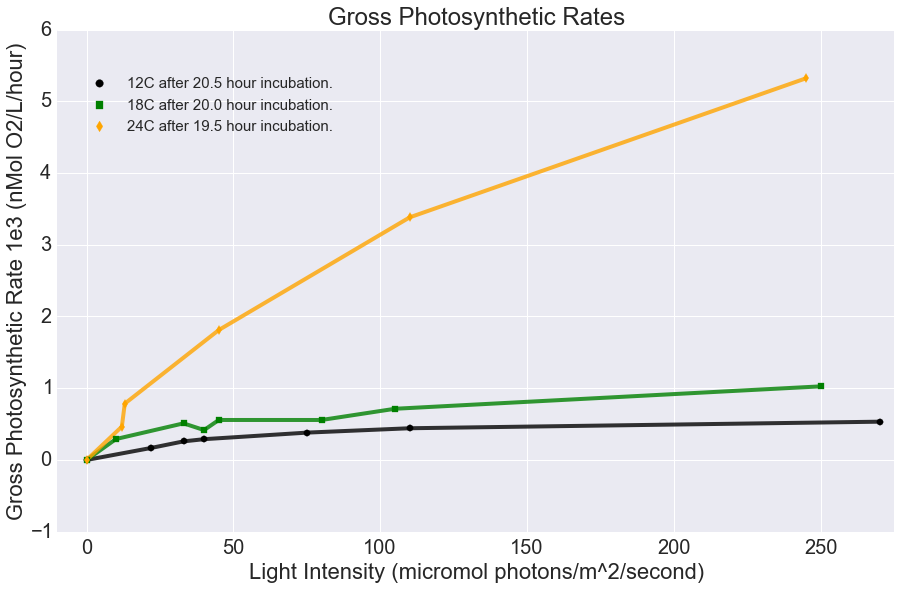

In [7]:
# initialize the plot
fig = plt.figure()     
ax = fig.add_subplot(111)    
ax.set_ylabel('Gross Photosynthetic Rate 1e3 (nMol O2/L/hour)')
ax.set_xlabel('Light Intensity (micromol photons/m^2/second)')
ax.set_xlim(-10,275)
#ax.set_ylim(-1,6)

# for each temperature regime let's plot the points!
for i in range(tempCount):
    plot2 = df2[df2.temp==temps[i]]
    
    x = plot2.parFlux
    y = plot2.grossPhotoRate/1e3
    
    ax.scatter(x,y,color=colorSwatch[i],s=40,marker=marker[i],label=str(temps[i])+"C after "+str(np.asarray(plot2.elapsedTime,dtype=np.float)[0])+" hour incubation.",zorder=10)
    ax.plot(x,y,color=colorSwatch[i],linewidth=4,alpha = .8,zorder=1)

    
ax.legend(scatterpoints=1,markerscale=1.2, loc='center',
                    bbox_to_anchor=(.18,.85),ncol=1,prop={'size':15},frameon=False)
plt.title('Gross Photosynthetic Rates')
plt.show();
    

Gross photosynthetic rate increases with temperature as well as light intensity. Is there photo inhibition present?

## Step 3 ## 
We can derive an index of phytosynthetic efficiency (in this case we mean photosynthetic efficiency in terms of oxygen produced per photon available) by dividing gross photosynthesis by the total photon flux to which the bottles were exposed during the incubation (hint: multiply PAR flux by the incubation duration). Fill in table 3 a-c to calculate this index of photosynthetic efficiency, then plot photosynthetic efficiency as a function of PAR flux for each temperature.

In [8]:
df2['photoEffIndex'] = (df2.grossPhotoRate)/(df2.parFlux*1000.*df2.elapsedTime*3600.)
print("Table 3. Index of Photosynthetic Efficiency")
df2[['temp','parFlux','elapsedTime','grossPhoto','photoEffIndex']]

Table 3. Index of Photosynthetic Efficiency


,temp,parFlux,elapsedTime,grossPhoto,photoEffIndex
0,12,270.000000,20.5,10937.500000,2.677590e-08
1,12,110.000000,20.5,9062.500000,5.445592e-08
2,12,75.000000,20.5,7812.500000,6.885231e-08
3,12,40.000000,20.5,5937.500000,9.811455e-08
4,12,33.000000,20.5,5312.500000,1.064081e-07
5,12,22.000000,20.5,3437.500000,1.032785e-07
6,18,250.000000,20.0,20520.833333,5.700231e-08
7,18,105.000000,20.0,14270.833333,9.438382e-08
8,18,80.000000,20.0,11145.833333,9.675203e-08
9,18,45.000000,20.0,11145.833333,1.720036e-07


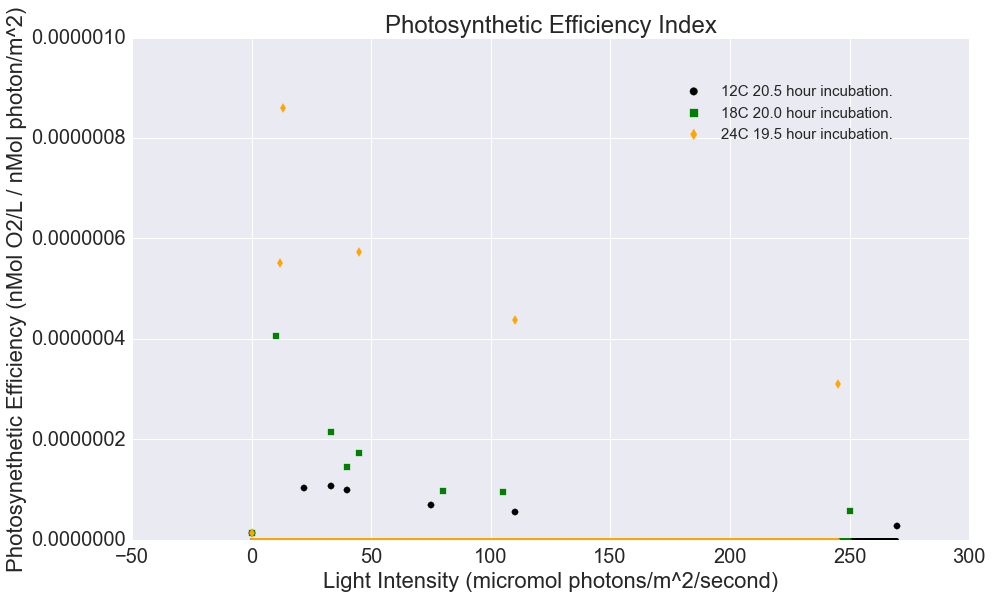

In [21]:
# initialize the plot
fig = plt.figure()     
ax = fig.add_subplot(111)    
ax.set_ylabel('Photosynethetic Efficiency (nMol O2/L / nMol photon/m^2)')
ax.set_xlabel('Light Intensity (micromol photons/m^2/second)')
#ax.set_xlim(-2,275)
ax.set_ylim(0,1e-6)

# for each temperature regime let's plot the points!
for i in range(tempCount):
    plot3 = df2[df2.temp==temps[i]]
    plot3.sort(columns='parFlux')

    x = plot3.parFlux
    y = plot3.photoEffIndex # divide by 1e11 to standardize points
    
    x1  =  np.linspace(x.min(),x.max(),5)
    y1 =   spline(x,y, x1)

    ax.plot(x1,y1,color=colorSwatch[i],linewidth=4)

    # Scatterplot 
    ax.scatter(x,y,color=colorSwatch[i],s=40,marker=marker[i],label=str(temps[i])+"C "+str(np.asarray(plot3.elapsedTime,dtype=np.float)[0])+" hour incubation.",zorder=10)
    #ax.plot(x,y,color=colorSwatch[i],linewidth=4)
ax.legend(scatterpoints=1,markerscale=1.2, loc='center',
                    bbox_to_anchor=(.78,.85),ncol=1,prop={'size':15},frameon=False)
plt.title('Photosynthetic Efficiency Index')
plt.show();
    

Comparing across all light levels, gross photosynthetic efficiency generally increases with temperature.
<br>Within any single temperature, gross photosynthetic efficiency generally increases as PAR flux increases.

## Step 4. 
Using the data in table 1 and the graph of gross photosynthetic rate as a function of PAR intensity (from step 2), fill in the values needed for table 4. Make a plot comparing respiration rate, gross photosynthetic rate at 33 μmole photos m-2 s-1, and gross photosynthetic rate at 250 μmole photos m-2 s-1.


In [10]:
# get the average Respiration rate per temp regime.
darkRate12 = dark.rateResp[dark.temp==12].mean()
darkRate18 = dark.rateResp[dark.temp==18].mean()
darkRate24 = dark.rateResp[dark.temp==24].mean()
darkRate = np.array([darkRate12,darkRate18,darkRate24])

# collect gross photosynthetic rates at ~45 micromole m-2 s-1 photons
pho45 = df2[df2.parFlux<=45]
pho45 = pho45[pho45.parFlux>=40]
pho45 = pho45[0:1].append(pho45[2:])
# collect gross photosynthetic rates at ~250 micromole m-2 s-1 photons
pho250 = df2[df2.parFlux>=240]

photoPAR = pd.DataFrame({'temp':temps,
                         'rateResp':darkRate,
                         'pho45':pho45.grossPhotoRate.values,
                         'pho250':pho250.grossPhotoRate.values})

print("Table 4. Gross Photosynthetic Rate as a Function of Light intensity (PAR)")
photoPAR[['temp','rateResp','pho45','pho250']]

Table 4. Gross Photosynthetic Rate as a Function of Light intensity (PAR)


,temp,rateResp,pho45,pho250
0,12,127.840909,289.634146,533.536585
1,18,881.782946,416.666667,1026.041667
2,24,4255.952381,1810.897436,5320.512821


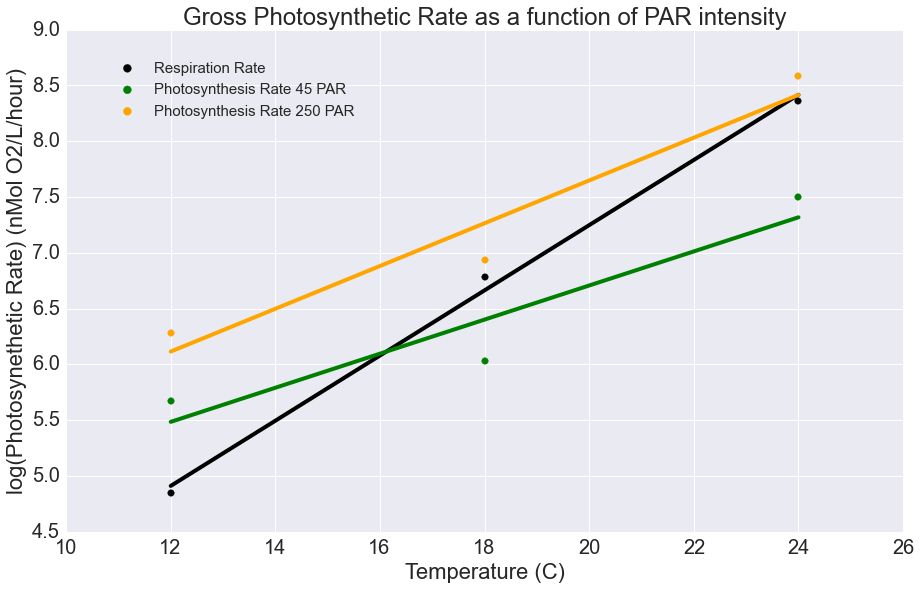

In [11]:
# initialize the plot
fig = plt.figure()     
ax = fig.add_subplot(111)  
ax.set_ylabel(r'log(Photosynethetic Rate) (nMol O2/L/hour)')
ax.set_xlabel('Temperature (C)')


y = np.log(darkRate.reshape(len(darkRate),1))
x = temps.reshape(len(temps),1)

ax.scatter(x,y,color='k',label="Respiration Rate",s=44)

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x,y)
ax.plot(x,regr.predict(x),color='k',linewidth=4)

y = np.log(pho45.grossPhotoRate).reshape(len(pho45.grossPhotoRate),1)
x = pho45.temp.reshape(len(pho45.temp),1)

ax.scatter(pho45.temp,np.log(pho45.grossPhotoRate),color='g',label="Photosynthesis Rate 45 PAR",s=44)

regr.fit(x,y)
ax.plot(x,regr.predict(x),color='g',linewidth=4)

y = np.log(pho250.grossPhotoRate).reshape(len(pho250.grossPhotoRate),1)
x = pho250.temp.reshape(len(pho250.temp),1)

ax.scatter(pho250.temp,np.log(pho250.grossPhotoRate),color='orange',label="Photosynthesis Rate 250 PAR",s=44)

regr.fit(x,y)
ax.plot(x,regr.predict(x),color='orange',linewidth=4)

ax.legend(scatterpoints=1,markerscale=1.2, loc='center',
                    bbox_to_anchor=(0.20,.88),ncol=1,prop={'size':15},frameon=False)
plt.title('Gross Photosynthetic Rate as a function of PAR intensity')
plt.show();

<function matplotlib.pyplot.show>

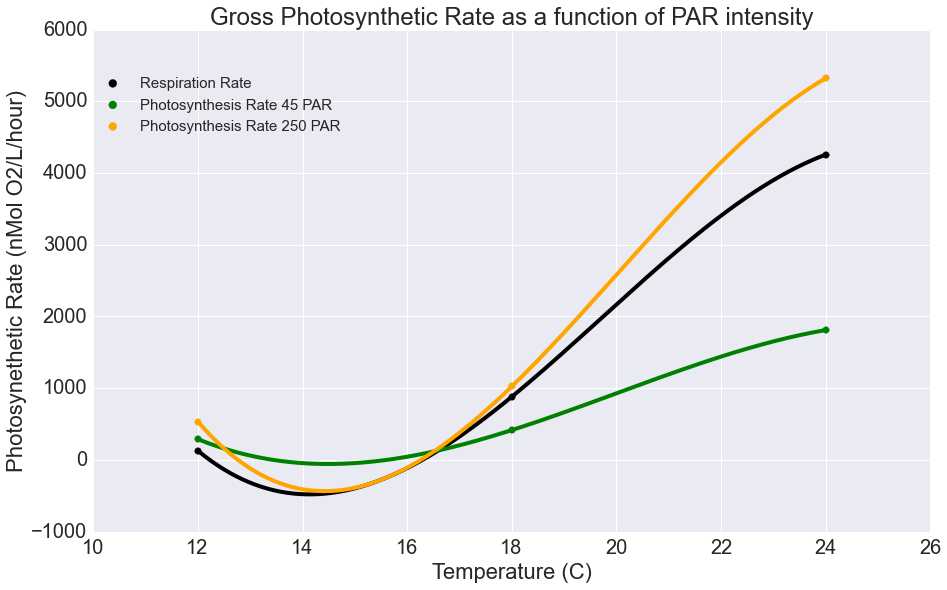

In [12]:
# initialize the plot
fig = plt.figure()     
ax = fig.add_subplot(111)  
ax.set_ylabel(r'Photosynethetic Rate (nMol O2/L/hour)')
ax.set_xlabel('Temperature (C)')

y = darkRate
x = temps

x1  =  np.linspace(x.min(),x.max(),300)
y1 =   spline(x,y, x1)

ax.plot(x1,y1,color='k',linewidth=4)
ax.scatter(x,y,color='k',label="Respiration Rate",s=44)


y = pho45.grossPhotoRate
x = pho45.temp

x1  =  np.linspace(x.min(),x.max(),300)
y1 =   spline(x,y, x1)

ax.plot(x1,y1,color='g',linewidth=4)
ax.scatter(pho45.temp,pho45.grossPhotoRate,color='g',label="Photosynthesis Rate 45 PAR",s=44)


y = pho250.grossPhotoRate
x = pho250.temp

x1  =  np.linspace(x.min(),x.max(),300)
y1 =   spline(x,y, x1)

ax.plot(x1,y1,color='orange',linewidth=4)
ax.scatter(pho250.temp,pho250.grossPhotoRate,color='orange',label="Photosynthesis Rate 250 PAR",s=44)

ax.legend(scatterpoints=1,markerscale=1.2, loc='center',
                    bbox_to_anchor=(0.15,.85),ncol=1,prop={'size':15},frameon=False)
plt.title('Gross Photosynthetic Rate as a function of PAR intensity')
plt.show

Comparing the temperature responses of respiration rate, gross photosynthetic rate at 33 μmole photos m-2 s-1, and gross photosynthetic rate at 250 μmole photos m-2 s-1 to each other, respiration rate was more sensitive (i.e., changed more per degree temperature increase) than photosynthetic rates.
<br>As light levels increase, temperature sensitivity of photosynthesis increases too.